# Node representation learning with Metapath2Vec


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/metapath2vec-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/metapath2vec-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

An example of implementing the Metapath2Vec representation learning algorithm using components from the `stellargraph` and `gensim` libraries.

**References**

**1.**  Metapath2Vec: Scalable Representation Learning for Heterogeneous Networks. Yuxiao Dong, Nitesh V. Chawla, and Ananthram Swami. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 135–144, 2017. ([link](https://ericdongyx.github.io/papers/KDD17-dong-chawla-swami-metapath2vec.pdf))

**2.** Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

**3.** Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

**4.** Social Computing Data Repository at ASU [http://socialcomputing.asu.edu]. R. Zafarani and H. Liu. Tempe, AZ: Arizona State University, School of Computing, Informatics and Decision Systems Engineering. 2009.

In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [1]:
!pip install git+https://github.com/VenkateshwaranB/stellargraph.git

  Cloning https://github.com/VenkateshwaranB/stellargraph.git to /tmp/pip-req-build-6frzk2rb
  Running command git clone --filter=blob:none --quiet https://github.com/VenkateshwaranB/stellargraph.git /tmp/pip-req-build-6frzk2rb
  Resolved https://github.com/VenkateshwaranB/stellargraph.git to commit efa1f847109a4ba490e7a5105646a20ee09a3243
  Preparing metadata (setup.py) ... done
  Created wheel for stellargraph: filename=stellargraph-1.3.0b0-py3-none-any.whl size=431845 sha256=7dd5da783c4a54c93a04e7011dedd6300d245c2ac9836bf3008681a17622ac6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-pda7zxrw/wheels/f3/06/0f/089f69af27d308a1830638f855b6c5755311d8ffc451de9980
Successfully built stellargraph


In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

## Load the dataset

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [6]:
dataset = datasets.BlogCatalog3()
display(HTML(dataset.description))
g = dataset.load()
print(
    "Number of nodes {} and number of edges {} in graph.".format(
        g.number_of_nodes(), g.number_of_edges()
    )
)

Number of nodes 10351 and number of edges 348459 in graph.


In [7]:
print(g.info())

StellarGraph: Undirected multigraph
 Nodes: 10351, Edges: 348459

 Node types:
  user: [10312]
    Features: none
    Edge types: user-belongs->group, user-friend->user
  group: [39]
    Features: none
    Edge types: group-belongs->user

 Edge types:
    user-friend->user: [333983]
        Weights: all 1 (default)
        Features: none
    group-belongs->user: [14476]
        Weights: all 1 (default)
        Features: none


In [8]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(g)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", edge_label="friend"
)

print(graph_test.info())

Network has 333983 edges of type friend
Network has 333983 edges of type friend
** Sampled 33398 positive and 33398 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 10351, Edges: 315061

 Node types:
  user: [10312]
    Features: none
    Edge types: user-belongs->group, user-friend->user
  group: [39]
    Features: none
    Edge types: group-belongs->user

 Edge types:
    user-friend->user: [300585]
        Weights: all 1 (default)
        Features: none
    group-belongs->user: [14476]
        Weights: all 1 (default)
        Features: none


In [9]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, g)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global", edge_label="friend"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

Network has 300585 edges of type friend
Network has 300585 edges of type friend
** Sampled 30058 positive and 30058 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 10351, Edges: 285003

 Node types:
  user: [10312]
    Features: none
    Edge types: user-belongs->group, user-friend->user
  group: [39]
    Features: none
    Edge types: group-belongs->user

 Edge types:
    user-friend->user: [270527]
        Weights: all 1 (default)
        Features: none
    group-belongs->user: [14476]
        Weights: all 1 (default)
        Features: none


In [10]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,45087,Train Graph,Test Graph,Train the Link Classifier
Model Selection,15029,Train Graph,Test Graph,Select the best Link Classifier model
Test set,66796,Test Graph,Full Graph,Evaluate the best Link Classifier


In [11]:
dimensions = 128
num_walks = 1
walk_length = 100
context_window_size = 10
num_iter = 1
workers = multiprocessing.cpu_count()
user_metapaths = [
    ["user", "group", "user"],
    ["user", "group", "user", "user"],
    ["user", "user"],
]

In [14]:
from stellargraph.data import UniformRandomMetaPathWalk
from gensim.models import Word2Vec


def metapath2vec_embedding(graph, name):
    rw = UniformRandomMetaPathWalk(graph)
    walks = rw.run(
        graph.nodes(), n=num_walks, length=walk_length, metapaths=user_metapaths
    )
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=dimensions,
        window=context_window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=num_iter,
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

In [15]:
embedding_train = metapath2vec_embedding(graph_train, "Train Graph")

Number of random walks for 'Train Graph': 30936


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [17]:
def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_l1, operator_l2]

In [18]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l2'


,ROC AUC score
name,
operator_l1,0.81730
operator_l2,0.82572


In [19]:
embedding_test = metapath2vec_embedding(graph_test, "Test Graph")

Number of random walks for 'Test Graph': 30936


In [20]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l2': 0.725951563542152


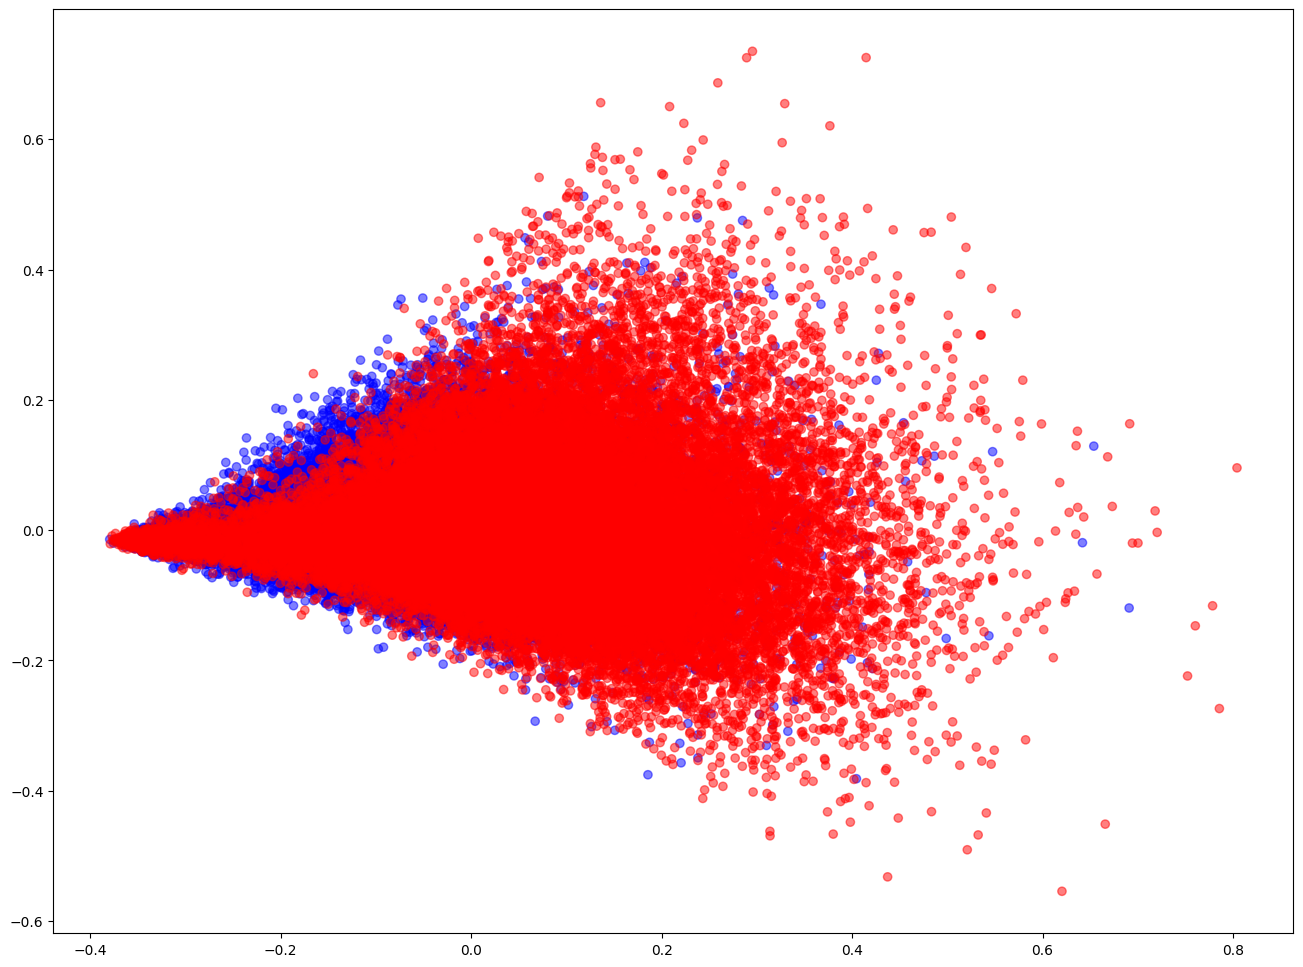

In [21]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

## The Metapath2Vec algorithm

The Metapath2Vec algorithm introduced in [1] is a 2-step representation learning algorithm. The two steps are:

1. Use uniform random walks to generate sentences from a graph. A sentence is a list of node IDs. The set of all sentences makes a corpus. The random walk is driven by a metapath that defines the node type order by which the random walker explores the graph.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node ID is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm [2] is used for calculating the embedding vectors.

## Corpus generation using random walks

The `stellargraph` library provides an implementation for uniform, first order, random walks as required by Metapath2Vec. The random walks have fixed maximum length and are controlled by the list of metapath schemas specified in parameter `metapaths`.

A metapath schema defines the type of node that the random walker is allowed to transition to from its current location. In the `stellargraph` implementation of metapath-driven random walks, the metapath schemas are given as a list of node types under the assumption that the input graph is not a multi-graph, i.e., two nodes are only connected by one edge type.

See [1] for a detailed description of metapath schemas and metapath-driven random walks.

For the **BlogCatalog3** dataset we use the following 3 metapaths.

- "user", "group", "user"
- "user", "group", "user", "user"
- "user", "user"



In [ ]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["user", "group", "user"],
    ["user", "group", "user", "user"],
    ["user", "user"],
]

In [ ]:
from stellargraph.data import UniformRandomMetaPathWalk

# Create the random walker
rw = UniformRandomMetaPathWalk(g)

walks = rw.run(
    nodes=list(g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=1,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 30936


## Representation Learning using Word2Vec

We use the Word2Vec [2] implementation in the free Python library gensim [3] to learn representations for each node in the graph.

We set the dimensionality of the learned embedding vectors to 128 as in [1].

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)

In [ ]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(10351, 128)

## Visualise Node Embeddings

We retrieve the Word2Vec node embeddings that are 128-dimensional vectors and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [g.node_type(node_id) for node_id in node_ids]

Transform the embeddings to 2d space for visualisation

In [ ]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

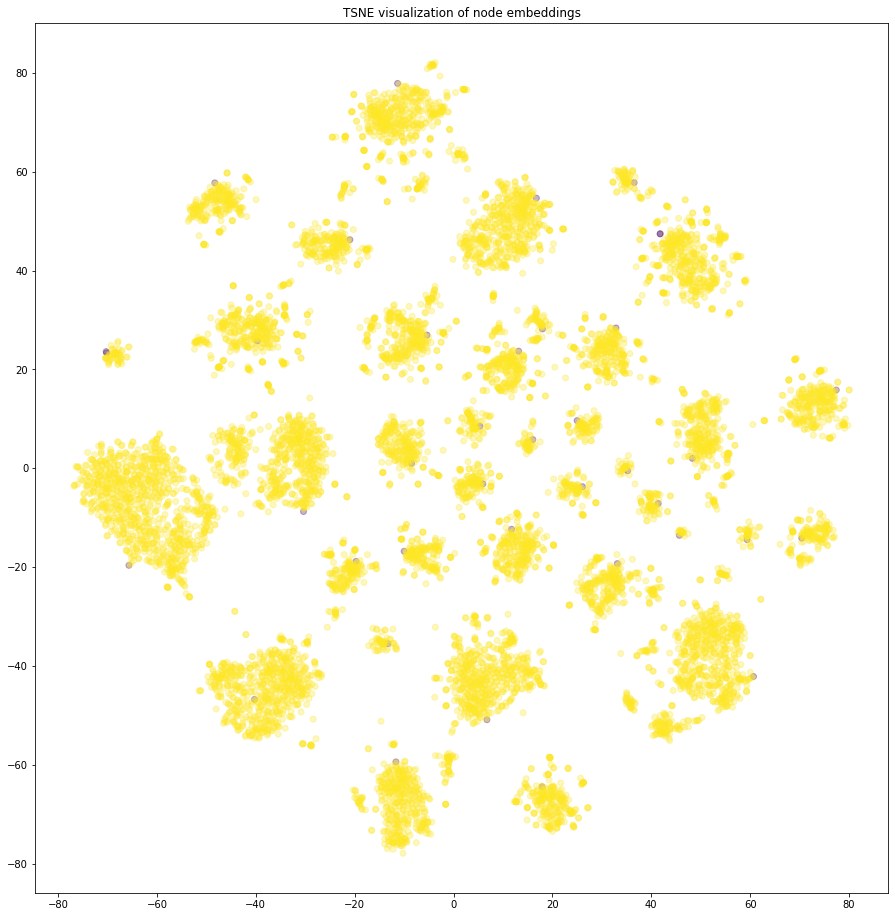

In [ ]:
# draw the points
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(20, 16))
plt.axes().set(aspect="equal")
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colours, alpha=0.3)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

## Downstream task

The node embeddings calculated using Metapath2Vec can be used as feature vectors in a downstream task such as node attribute inference (e.g., inferring the gender or age attribute of 'user' nodes), community detection (e.g., clustering of 'user' nodes based on the similarity of their embedding vectors), and link prediction (e.g., prediction of friendship relation between 'user' nodes).

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/embeddings/metapath2vec-embeddings.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/embeddings/metapath2vec-embeddings.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>